In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf

import utils

/home/ifled/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
#SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
#WORK_DIRECTORY = 'data'
#IMAGE_SIZE = 28
#NUM_CHANNELS = 1
#PIXEL_DEPTH = 255
#NUM_LABELS = 10
#VALIDATION_SIZE = 5000  # Size of the validation set.
#SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 100
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.
DATASET = 'cifar10'

NUM_UNROLL_STEPS = 5

### Like 2_stage/confnn_gated_cifar10.ipynb, but use architecture from tf baseline
### apply gating to all layers

In [5]:
# took architecture from here: https://github.com/tensorflow/models/blob/f798e4b5504b0b7ed08f7b7a03fc5a79f00b9f21/tutorials/image/cifar10/cifar10.py#L188

def model_step(input_images, prior, batch_size, training, num_labels, use_priors):
    """The Model definition."""
    def get_gates_and_bias(layer_sizes):
        gates = prior
        bias = prior
        for size in layer_sizes[:-1]:
            gates = tf.layers.dense(inputs=gates, units=size, activation=tf.nn.relu)
            bias = tf.layers.dense(inputs=bias, units=size, activation=tf.nn.relu)
        gates = tf.layers.dense(inputs=gates, units=layer_sizes[-1], activation=tf.nn.sigmoid)
        bias = tf.layers.dense(inputs=bias, units=layer_sizes[-1], activation=None)
        return gates, bias
        
    def apply_gating_on_conv(tensor, layer_sizes):
        if not use_priors:
            return tensor
        num_channels = tensor.get_shape()[-1]
        gates, bias = get_gates_and_bias(layer_sizes + (num_channels, ))
        gates = tf.expand_dims(tf.expand_dims(gates, axis=1), axis=1)
        bias = tf.expand_dims(tf.expand_dims(bias, axis=1), axis=1)
        return tf.multiply(tensor, gates) + bias
    
    def apply_gating_on_dense(tensor, layer_sizes):
        if not use_priors:
            return tensor
        num_units = tensor.get_shape()[1]
        gates, bias = get_gates_and_bias(layer_sizes + (num_units, ))
        return tf.multiply(tensor, gates) + bias
    
    LAYERS = (100,)
    
    inputs = input_images
    
    conv1 = tf.layers.conv2d(
        inputs=inputs,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2, padding='same')
    
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    norm1 = apply_gating_on_conv(norm1, LAYERS)

    conv2 = tf.layers.conv2d(
        inputs=norm1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    norm2 = apply_gating_on_conv(norm2, LAYERS)
    
    pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2, padding='same')
    
    pool2_shape = pool2.get_shape()
    num_units_after_conv = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]

    pool2_flat = tf.reshape(pool2, [-1, num_units_after_conv])
    pool2_flat = apply_gating_on_dense(pool2_flat, LAYERS)
    
    
    dense1 = tf.layers.dense(inputs=pool2_flat, units=384, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    dense1 = apply_gating_on_dense(dense1, LAYERS)
    
    dense2 = tf.layers.dense(inputs=dense1, units=192, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    dense2 = apply_gating_on_dense(dense2, LAYERS)

    logits = tf.layers.dense(inputs=dense2, units=num_labels)
    logits = apply_gating_on_dense(logits, LAYERS)
    posteriors = tf.nn.softmax(logits)
    
    return logits, posteriors


def apply(input_images, training, train_labels_node, num_labels, use_priors):
    results = []
    loss = 0.0

    batch_size = input_images.get_shape()[0]
    priors = tf.ones((batch_size, num_labels)) / num_labels
    for step in range(NUM_UNROLL_STEPS):
        with tf.variable_scope('one_step', reuse=(step > 0)):
            logits, posteriors = model_step(input_images, priors, batch_size,
                                            training=training, num_labels=num_labels,
                                            use_priors=use_priors)
        priors = posteriors
        results.append((logits, posteriors))
        loss += tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=train_labels_node, logits=logits))
    return tf.stack([logits for (logits, _) in results]), loss

In [6]:
use_priors = True

tf.reset_default_graph()

dataset = utils.get_dataset(DATASET)

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=tf.float32)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    1e-3,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    dataset.train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_config = dict(
    optimizer=optimizer,
    batch_var=batch,
    learning_rate_var=learning_rate,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    eval_frequency=EVAL_FREQUENCY,
)

history_1, stdout_lines = utils.run_train(apply, train_config, dataset,
                                        build_func_kwargs=dict(use_priors=use_priors))

Initialized!
Step 0 (epoch 0.00), 69.3 ms
Minibatch loss: 11.420, learning rate: 0.001000
Minibatch error: [73.4375, 82.8125, 82.8125, 82.8125, 82.8125]
Validation error: [86.78, 89.36, 89.28, 89.28, 89.28]
Step 100 (epoch 0.14), 212.0 ms
Minibatch loss: 9.705, learning rate: 0.001000
Minibatch error: [68.75, 71.875, 71.875, 71.875, 71.875]
Validation error: [68.28, 68.0, 67.92, 67.9, 67.84]
Step 200 (epoch 0.28), 211.9 ms
Minibatch loss: 7.777, learning rate: 0.001000
Minibatch error: [60.9375, 60.9375, 57.8125, 57.8125, 57.8125]
Validation error: [57.84, 57.5, 57.7, 57.64, 57.62]
Step 300 (epoch 0.43), 211.7 ms
Minibatch loss: 6.926, learning rate: 0.001000
Minibatch error: [54.6875, 51.5625, 53.125, 51.5625, 51.5625]
Validation error: [51.3, 51.7, 51.16, 51.36, 51.34]
Step 400 (epoch 0.57), 211.8 ms
Minibatch loss: 6.936, learning rate: 0.001000
Minibatch error: [48.4375, 46.875, 48.4375, 46.875, 46.875]
Validation error: [47.54, 47.58, 47.38, 47.44, 47.56]
Step 500 (epoch 0.71), 21

Step 3700 (epoch 5.26), 212.1 ms
Minibatch loss: 0.759, learning rate: 0.000774
Minibatch error: [6.25, 6.25, 6.25, 6.25, 6.25]
Validation error: [27.900000000000006, 27.64, 27.480000000000004, 27.459999999999994, 27.519999999999996]
Step 3800 (epoch 5.40), 212.2 ms
Minibatch loss: 1.129, learning rate: 0.000774
Minibatch error: [4.6875, 4.6875, 4.6875, 4.6875, 4.6875]
Validation error: [28.379999999999995, 28.120000000000005, 28.019999999999996, 27.959999999999994, 27.980000000000004]
Step 3900 (epoch 5.55), 212.3 ms
Minibatch loss: 0.298, learning rate: 0.000774
Minibatch error: [1.5625, 0.0, 0.0, 0.0, 0.0]
Validation error: [29.239999999999995, 28.560000000000002, 28.739999999999995, 28.64, 28.680000000000007]
Step 4000 (epoch 5.69), 211.9 ms
Minibatch loss: 0.589, learning rate: 0.000774
Minibatch error: [3.125, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [28.819999999999993, 29.0, 28.92, 28.92, 28.92]
Step 4100 (epoch 5.83), 212.1 ms
Minibatch loss: 0.914, learning rate: 0.0

Step 7300 (epoch 10.38), 212.3 ms
Minibatch loss: 0.059, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.060000000000002, 26.060000000000002, 25.92, 26.040000000000006, 26.019999999999996]
Step 7400 (epoch 10.52), 212.1 ms
Minibatch loss: 0.091, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.200000000000003, 27.540000000000006, 27.36, 27.439999999999998, 27.400000000000006]
Step 7500 (epoch 10.67), 212.0 ms
Minibatch loss: 0.053, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.5, 26.319999999999993, 26.200000000000003, 26.260000000000005, 26.260000000000005]
Step 7600 (epoch 10.81), 212.3 ms
Minibatch loss: 0.044, learning rate: 0.000599
Minibatch error: [1.5625, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.480000000000004, 26.400000000000006, 26.459999999999994, 26.340000000000003, 26.439999999999998]
Step 7700 (epoch 10.95), 212.1 ms
Minibatch loss: 0.068, learning

Step 10900 (epoch 15.50), 212.0 ms
Minibatch loss: 0.030, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.060000000000002, 26.040000000000006, 25.92, 25.980000000000004, 25.879999999999995]
Step 11000 (epoch 15.64), 212.2 ms
Minibatch loss: 0.045, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.86, 27.019999999999996, 26.78, 27.060000000000002, 26.900000000000006]
Step 11100 (epoch 15.79), 212.1 ms
Minibatch loss: 0.019, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.42, 25.700000000000003, 25.599999999999994, 25.700000000000003, 25.5]
Step 11200 (epoch 15.93), 212.2 ms
Minibatch loss: 0.029, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.42, 25.58, 25.200000000000003, 25.560000000000002, 25.400000000000006]
Step 11300 (epoch 16.07), 212.2 ms
Minibatch loss: 0.026, learning rate: 0.000440
Minibatch error: [0.0, 0.0, 0.0, 0

Step 14600 (epoch 20.76), 212.7 ms
Minibatch loss: 0.009, learning rate: 0.000358
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.519999999999996, 25.540000000000006, 25.459999999999994, 25.5, 25.5]
Step 14700 (epoch 20.91), 212.4 ms
Minibatch loss: 0.011, learning rate: 0.000358
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.36, 25.239999999999995, 25.239999999999995, 25.319999999999993, 25.299999999999997]
Step 14800 (epoch 21.05), 212.3 ms
Minibatch loss: 0.006, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.819999999999993, 24.959999999999994, 24.959999999999994, 24.92]
Step 14900 (epoch 21.19), 212.5 ms
Minibatch loss: 0.001, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.239999999999995, 25.159999999999997, 25.08, 25.340000000000003, 25.28]
Step 15000 (epoch 21.33), 212.2 ms
Minibatch loss: 0.005, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.

Step 18300 (epoch 26.03), 212.4 ms
Minibatch loss: 0.007, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.900000000000006, 25.92, 25.799999999999997, 25.840000000000003, 25.760000000000005]
Step 18400 (epoch 26.17), 212.2 ms
Minibatch loss: 0.001, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.599999999999994, 25.5, 25.599999999999994, 25.58, 25.540000000000006]
Step 18500 (epoch 26.31), 212.6 ms
Minibatch loss: 0.002, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.060000000000002, 26.08, 26.060000000000002, 26.019999999999996, 26.060000000000002]
Step 18600 (epoch 26.45), 213.1 ms
Minibatch loss: 0.010, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.019999999999996, 24.900000000000006, 25.019999999999996, 25.040000000000006, 25.040000000000006]
Step 18700 (epoch 26.60), 212.3 ms
Minibatch loss: 0.005, learning rate: 0.00

Step 22000 (epoch 31.29), 212.5 ms
Minibatch loss: 0.001, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.400000000000006, 25.340000000000003, 25.379999999999995, 25.42, 25.379999999999995]
Step 22100 (epoch 31.43), 212.3 ms
Minibatch loss: 0.001, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.099999999999994, 24.959999999999994, 25.200000000000003, 25.180000000000007, 25.260000000000005]
Step 22200 (epoch 31.57), 212.4 ms
Minibatch loss: 0.008, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.439999999999998, 25.400000000000006, 25.319999999999993, 25.459999999999994]
Step 22300 (epoch 31.72), 212.4 ms
Minibatch loss: 0.001, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.840000000000003, 24.680000000000007, 24.760000000000005, 24.78, 24.659999999999997]
Step 22400 (epoch 31.86), 212.2 ms
Minibatch loss:

Step 25700 (epoch 36.55), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.439999999999998, 24.159999999999997, 24.200000000000003, 24.260000000000005, 24.239999999999995]
Step 25800 (epoch 36.69), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.5, 24.14, 24.200000000000003, 24.22, 24.239999999999995]
Step 25900 (epoch 36.84), 212.2 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.5, 24.159999999999997, 24.22, 24.260000000000005, 24.319999999999993]
Step 26000 (epoch 36.98), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.459999999999994, 24.14, 24.180000000000007, 24.28, 24.299999999999997]
Step 26100 (epoch 37.12), 212.0 ms
Minibatch loss: 0.000, learning rate: 0.000150
Minibatch error: [0.0, 0.0, 0.0, 0.

Step 29400 (epoch 41.81), 212.2 ms
Minibatch loss: 0.000, learning rate: 0.000122
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.519999999999996, 24.040000000000006, 24.08, 24.120000000000005, 24.159999999999997]
Step 29500 (epoch 41.96), 212.0 ms
Minibatch loss: 0.000, learning rate: 0.000122
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.540000000000006, 24.060000000000002, 24.099999999999994, 24.08, 24.159999999999997]
Step 29600 (epoch 42.10), 212.4 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.459999999999994, 24.120000000000005, 24.099999999999994, 24.120000000000005, 24.14]
Step 29700 (epoch 42.24), 212.1 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.379999999999995, 24.08, 24.08, 24.14, 24.120000000000005]
Step 29800 (epoch 42.38), 212.2 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.

Step 33100 (epoch 47.08), 211.7 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.36, 24.060000000000002, 23.959999999999994, 23.980000000000004, 24.040000000000006]
Step 33200 (epoch 47.22), 211.9 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.340000000000003, 24.019999999999996, 24.040000000000006, 24.0, 24.060000000000002]
Step 33300 (epoch 47.36), 212.0 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.379999999999995, 24.019999999999996, 24.0, 24.120000000000005, 24.060000000000002]
Step 33400 (epoch 47.50), 211.7 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.340000000000003, 24.019999999999996, 23.939999999999998, 23.980000000000004, 23.939999999999998]
Step 33500 (epoch 47.64), 211.9 ms
Minibatch loss: 0.000, learnin

Step 36700 (epoch 52.20), 210.9 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.299999999999997, 24.0, 23.959999999999994, 23.980000000000004, 23.980000000000004]
Step 36800 (epoch 52.34), 210.5 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.0, 23.939999999999998, 23.980000000000004, 24.019999999999996]
Step 36900 (epoch 52.48), 210.6 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.0, 23.959999999999994, 24.060000000000002, 24.060000000000002]
Step 37000 (epoch 52.62), 210.7 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.0, 24.019999999999996, 24.0, 24.019999999999996]
Step 37100 (epoch 52.76), 210.6 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch er

Step 40400 (epoch 57.46), 211.4 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 23.980000000000004, 23.959999999999994, 24.0, 23.900000000000006]
Step 40500 (epoch 57.60), 211.5 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.200000000000003, 23.92, 23.92, 23.980000000000004, 23.959999999999994]
Step 40600 (epoch 57.74), 211.3 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 23.939999999999998, 23.879999999999995, 23.959999999999994, 23.939999999999998]
Step 40700 (epoch 57.88), 211.5 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.040000000000006, 23.939999999999998, 24.019999999999996, 24.0]
Step 40800 (epoch 58.03), 211.3 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch error: [0.0,

Step 44100 (epoch 62.72), 212.9 ms
Minibatch loss: 0.000, learning rate: 0.000042
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.120000000000005, 24.0, 23.959999999999994, 24.019999999999996, 24.0]
Step 44200 (epoch 62.86), 213.0 ms
Minibatch loss: 0.000, learning rate: 0.000042
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.159999999999997, 24.040000000000006, 23.959999999999994, 24.0, 23.92]
Step 44300 (epoch 63.00), 212.1 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.120000000000005, 24.08, 24.019999999999996, 24.040000000000006, 24.040000000000006]
Step 44400 (epoch 63.15), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.120000000000005, 24.08, 23.959999999999994, 24.08, 23.959999999999994]
Step 44500 (epoch 63.29), 212.0 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0

Step 47800 (epoch 67.98), 212.5 ms
Minibatch loss: 0.000, learning rate: 0.000032
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.08, 24.019999999999996, 24.08, 24.060000000000002, 24.040000000000006]
Step 47900 (epoch 68.12), 212.2 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.099999999999994, 24.040000000000006, 24.019999999999996, 24.060000000000002, 23.980000000000004]
Step 48000 (epoch 68.27), 212.6 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.040000000000006, 24.060000000000002, 23.980000000000004, 23.980000000000004, 23.939999999999998]
Step 48100 (epoch 68.41), 212.2 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.959999999999994, 23.92, 23.900000000000006, 23.939999999999998, 23.879999999999995]
Step 48200 (epoch 68.55), 212.7 ms
Minibatch loss: 0.000, learn

Step 51400 (epoch 73.10), 212.4 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.08, 24.099999999999994, 24.060000000000002, 24.060000000000002, 24.040000000000006]
Step 51500 (epoch 73.24), 212.2 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.980000000000004, 24.08, 24.060000000000002, 24.0, 24.0]
Step 51600 (epoch 73.39), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.060000000000002, 24.040000000000006, 24.019999999999996, 24.060000000000002, 24.060000000000002]
Step 51700 (epoch 73.53), 212.4 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.099999999999994, 23.959999999999994, 23.92, 23.92, 23.939999999999998]
Step 51800 (epoch 73.67), 212.1 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0,

Step 55100 (epoch 78.36), 212.5 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.099999999999994, 24.099999999999994, 24.040000000000006, 24.08, 24.08]
Step 55200 (epoch 78.51), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.099999999999994, 24.019999999999996, 23.980000000000004, 24.08, 24.120000000000005]
Step 55300 (epoch 78.65), 212.4 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.099999999999994, 24.120000000000005, 24.14, 24.14]
Step 55400 (epoch 78.79), 212.6 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.120000000000005, 24.120000000000005, 24.08, 24.14, 24.120000000000005]
Step 55500 (epoch 78.93), 212.1 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 

Step 58800 (epoch 83.63), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.239999999999995, 24.180000000000007, 24.120000000000005, 24.120000000000005, 24.159999999999997]
Step 58900 (epoch 83.77), 212.0 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 24.200000000000003, 24.120000000000005, 24.14, 24.159999999999997]
Step 59000 (epoch 83.91), 212.1 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.200000000000003, 24.120000000000005, 24.200000000000003, 24.200000000000003]
Step 59100 (epoch 84.05), 212.4 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.28, 24.260000000000005, 24.120000000000005, 24.099999999999994, 24.22]
Step 59200 (epoch 84.20), 212.1 ms
Minibatch loss: 0.000, learning rate: 0.0

Step 62500 (epoch 88.89), 212.5 ms
Minibatch loss: 0.000, learning rate: 0.000011
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.200000000000003, 24.260000000000005, 24.200000000000003, 24.22, 24.22]
Step 62600 (epoch 89.03), 212.2 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.319999999999993, 24.260000000000005, 24.200000000000003, 24.22, 24.260000000000005]
Step 62700 (epoch 89.17), 212.5 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.260000000000005, 24.200000000000003, 24.200000000000003, 24.180000000000007]
Step 62800 (epoch 89.32), 212.2 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.28, 24.22, 24.200000000000003, 24.200000000000003, 24.22]
Step 62900 (epoch 89.46), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.

Step 66300 (epoch 94.29), 212.4 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.299999999999997, 24.299999999999997, 24.200000000000003, 24.28]
Step 66400 (epoch 94.44), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.239999999999995, 24.22, 24.200000000000003, 24.180000000000007]
Step 66500 (epoch 94.58), 212.1 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.28, 24.22, 24.159999999999997, 24.22, 24.22]
Step 66600 (epoch 94.72), 211.8 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.28, 24.200000000000003, 24.22, 24.260000000000005]
Step 66700 (epoch 94.86), 211.6 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Val

Step 70000 (epoch 99.56), 212.4 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.299999999999997, 24.260000000000005, 24.22, 24.200000000000003, 24.200000000000003]
Step 70100 (epoch 99.70), 212.4 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.28, 24.299999999999997, 24.239999999999995, 24.180000000000007, 24.200000000000003]
Step 70200 (epoch 99.84), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.319999999999993, 24.239999999999995, 24.22, 24.22]
Step 70300 (epoch 99.98), 212.3 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.299999999999997, 24.28, 24.239999999999995, 24.22, 24.200000000000003]
Test error: [25.620000000000005, 25.620000000000005, 25.659999999999997, 25.64, 25.650000000000006]


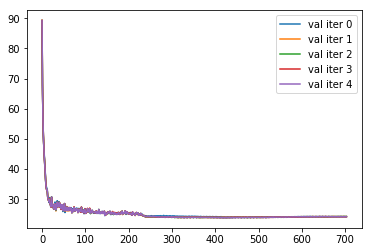

In [14]:
utils.plot_error_on_iterations(history_1, [None, None], [0, 1, 2, 3, 4])

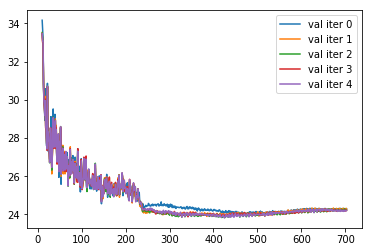

In [15]:
utils.plot_error_on_iterations(history_1, [10, None], [0, 1, 2, 3, 4])

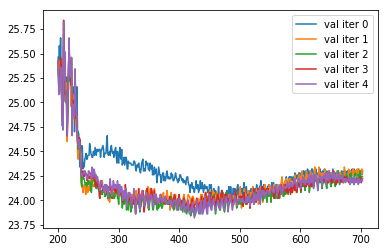

In [16]:
utils.plot_error_on_iterations(history_1, [200, None], [0, 1, 2, 3, 4])

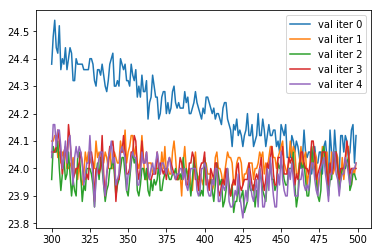

In [17]:
utils.plot_error_on_iterations(history_1, [300, 500], [0, 1, 2, 3, 4])

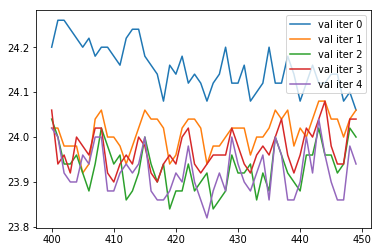

In [18]:
utils.plot_error_on_iterations(history_1, [400, 450], [0, 1, 2, 3, 4])

## Insert two layers (100, 100) instead of one for each gate and bias

In [12]:
# took architecture from here: https://github.com/tensorflow/models/blob/f798e4b5504b0b7ed08f7b7a03fc5a79f00b9f21/tutorials/image/cifar10/cifar10.py#L188

def model_step(input_images, prior, batch_size, training, num_labels, use_priors):
    """The Model definition."""
    def get_gates_and_bias(layer_sizes):
        gates = prior
        bias = prior
        for size in layer_sizes[:-1]:
            gates = tf.layers.dense(inputs=gates, units=size, activation=tf.nn.relu)
            bias = tf.layers.dense(inputs=bias, units=size, activation=tf.nn.relu)
        gates = tf.layers.dense(inputs=gates, units=layer_sizes[-1], activation=tf.nn.sigmoid)
        bias = tf.layers.dense(inputs=bias, units=layer_sizes[-1], activation=None)
        return gates, bias
        
    def apply_gating_on_conv(tensor, layer_sizes):
        if not use_priors:
            return tensor
        num_channels = tensor.get_shape()[-1]
        gates, bias = get_gates_and_bias(layer_sizes + (num_channels, ))
        gates = tf.expand_dims(tf.expand_dims(gates, axis=1), axis=1)
        bias = tf.expand_dims(tf.expand_dims(bias, axis=1), axis=1)
        return tf.multiply(tensor, gates) + bias
    
    def apply_gating_on_dense(tensor, layer_sizes):
        if not use_priors:
            return tensor
        num_units = tensor.get_shape()[1]
        gates, bias = get_gates_and_bias(layer_sizes + (num_units, ))
        return tf.multiply(tensor, gates) + bias
    
    LAYERS = (100, 100)
    
    inputs = input_images
    
    conv1 = tf.layers.conv2d(
        inputs=inputs,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2, padding='same')
    
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    norm1 = apply_gating_on_conv(norm1, LAYERS)

    conv2 = tf.layers.conv2d(
        inputs=norm1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    norm2 = apply_gating_on_conv(norm2, LAYERS)
    
    pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2, padding='same')
    
    pool2_shape = pool2.get_shape()
    num_units_after_conv = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]

    pool2_flat = tf.reshape(pool2, [-1, num_units_after_conv])
    pool2_flat = apply_gating_on_dense(pool2_flat, LAYERS)
    
    
    dense1 = tf.layers.dense(inputs=pool2_flat, units=384, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    dense1 = apply_gating_on_dense(dense1, LAYERS)
    
    dense2 = tf.layers.dense(inputs=dense1, units=192, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    dense2 = apply_gating_on_dense(dense2, LAYERS)

    logits = tf.layers.dense(inputs=dense2, units=num_labels)
    logits = apply_gating_on_dense(logits, LAYERS)
    posteriors = tf.nn.softmax(logits)
    
    return logits, posteriors


def apply(input_images, training, train_labels_node, num_labels, use_priors):
    results = []
    loss = 0.0

    batch_size = input_images.get_shape()[0]
    priors = tf.ones((batch_size, num_labels)) / num_labels
    for step in range(NUM_UNROLL_STEPS):
        with tf.variable_scope('one_step', reuse=(step > 0)):
            logits, posteriors = model_step(input_images, priors, batch_size,
                                            training=training, num_labels=num_labels,
                                            use_priors=use_priors)
        priors = posteriors
        results.append((logits, posteriors))
        loss += tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=train_labels_node, logits=logits))
    return tf.stack([logits for (logits, _) in results]), loss

In [13]:
use_priors = True

tf.reset_default_graph()

dataset = utils.get_dataset(DATASET)

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=tf.float32)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    1e-3,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    dataset.train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_config = dict(
    optimizer=optimizer,
    batch_var=batch,
    learning_rate_var=learning_rate,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    eval_frequency=EVAL_FREQUENCY,
)

history_3, stdout_lines = utils.run_train(apply, train_config, dataset,
                                          build_func_kwargs=dict(use_priors=use_priors))

Initialized!
Step 0 (epoch 0.00), 52.6 ms
Minibatch loss: 11.484, learning rate: 0.001000
Minibatch error: [87.5, 84.375, 84.375, 84.375, 84.375]
Validation error: [88.94, 88.94, 88.9, 88.9, 88.9]
Step 100 (epoch 0.14), 235.5 ms
Minibatch loss: 8.946, learning rate: 0.001000
Minibatch error: [59.375, 59.375, 62.5, 60.9375, 60.9375]
Validation error: [64.88, 64.36, 64.38, 64.46000000000001, 64.47999999999999]
Step 200 (epoch 0.28), 235.3 ms
Minibatch loss: 7.509, learning rate: 0.001000
Minibatch error: [50.0, 46.875, 48.4375, 48.4375, 48.4375]
Validation error: [55.5, 55.54, 55.62, 55.52, 55.54]
Step 300 (epoch 0.43), 235.3 ms
Minibatch loss: 6.607, learning rate: 0.001000
Minibatch error: [45.3125, 46.875, 45.3125, 46.875, 45.3125]
Validation error: [49.52, 49.68, 49.24, 49.36, 49.26]
Step 400 (epoch 0.57), 235.2 ms
Minibatch loss: 6.292, learning rate: 0.001000
Minibatch error: [46.875, 43.75, 45.3125, 45.3125, 45.3125]
Validation error: [46.26, 45.82, 46.0, 45.76, 45.82]
Step 500 (e

Step 4100 (epoch 5.83), 235.6 ms
Minibatch loss: 0.711, learning rate: 0.000774
Minibatch error: [7.8125, 6.25, 6.25, 6.25, 6.25]
Validation error: [29.040000000000006, 28.959999999999994, 28.840000000000003, 28.879999999999995, 28.879999999999995]
Step 4200 (epoch 5.97), 235.9 ms
Minibatch loss: 0.416, learning rate: 0.000774
Minibatch error: [0.0, 4.6875, 4.6875, 4.6875, 4.6875]
Validation error: [29.379999999999995, 29.159999999999997, 29.120000000000005, 29.08, 29.060000000000002]
Step 4300 (epoch 6.12), 236.1 ms
Minibatch loss: 0.401, learning rate: 0.000735
Minibatch error: [0.0, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [28.400000000000006, 28.560000000000002, 28.5, 28.5, 28.5]
Step 4400 (epoch 6.26), 236.5 ms
Minibatch loss: 0.284, learning rate: 0.000735
Minibatch error: [1.5625, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [27.680000000000007, 27.58, 27.58, 27.540000000000006, 27.560000000000002]
Step 4500 (epoch 6.40), 236.2 ms
Minibatch loss: 0.501, learning ra

Step 7700 (epoch 10.95), 236.4 ms
Minibatch loss: 0.034, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.799999999999997, 26.739999999999995, 26.72, 26.760000000000005, 26.78]
Step 7800 (epoch 11.09), 235.4 ms
Minibatch loss: 0.047, learning rate: 0.000569
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.78, 27.019999999999996, 27.040000000000006, 27.099999999999994, 27.060000000000002]
Step 7900 (epoch 11.24), 235.5 ms
Minibatch loss: 0.007, learning rate: 0.000569
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.040000000000006, 27.060000000000002, 27.08, 27.040000000000006, 27.08]
Step 8000 (epoch 11.38), 236.3 ms
Minibatch loss: 0.085, learning rate: 0.000569
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.959999999999994, 26.78, 26.72, 26.64, 26.680000000000007]
Step 8100 (epoch 11.52), 235.5 ms
Minibatch loss: 0.023, learning rate: 0.000569
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validati

Step 11300 (epoch 16.07), 237.2 ms
Minibatch loss: 0.008, learning rate: 0.000440
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.120000000000005, 26.299999999999997, 26.340000000000003, 26.340000000000003, 26.340000000000003]
Step 11400 (epoch 16.21), 236.1 ms
Minibatch loss: 0.003, learning rate: 0.000440
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.739999999999995, 26.819999999999993, 26.58, 26.700000000000003, 26.620000000000005]
Step 11500 (epoch 16.36), 236.4 ms
Minibatch loss: 0.009, learning rate: 0.000440
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.060000000000002, 27.060000000000002, 27.08, 27.180000000000007, 27.099999999999994]
Step 11600 (epoch 16.50), 236.0 ms
Minibatch loss: 0.012, learning rate: 0.000440
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.58, 26.480000000000004, 26.540000000000006, 26.42, 26.439999999999998]
Step 11700 (epoch 16.64), 236.1 ms
Minibatch loss: 0.004, learning rate: 0.0

Step 14900 (epoch 21.19), 236.8 ms
Minibatch loss: 0.005, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.260000000000005, 26.120000000000005, 26.159999999999997, 26.099999999999994, 26.180000000000007]
Step 15000 (epoch 21.33), 236.9 ms
Minibatch loss: 0.029, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.239999999999995, 26.400000000000006, 26.540000000000006, 26.58, 26.58]
Step 15100 (epoch 21.48), 236.9 ms
Minibatch loss: 0.017, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.120000000000005, 26.180000000000007, 26.200000000000003, 26.159999999999997, 26.060000000000002]
Step 15200 (epoch 21.62), 236.8 ms
Minibatch loss: 0.000, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.040000000000006, 26.040000000000006, 25.900000000000006, 25.900000000000006, 25.939999999999998]
Step 15300 (epoch 21.76), 237.0 ms
Minibatch loss:

Step 18600 (epoch 26.45), 237.1 ms
Minibatch loss: 0.003, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.700000000000003, 26.459999999999994, 26.459999999999994, 26.439999999999998, 26.439999999999998]
Step 18700 (epoch 26.60), 237.0 ms
Minibatch loss: 0.001, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.260000000000005, 26.28, 26.260000000000005, 26.36, 26.36]
Step 18800 (epoch 26.74), 236.6 ms
Minibatch loss: 0.001, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.620000000000005, 25.519999999999996, 25.58, 25.620000000000005]
Step 18900 (epoch 26.88), 237.1 ms
Minibatch loss: 0.005, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.560000000000002, 25.400000000000006, 25.379999999999995, 25.340000000000003, 25.319999999999993]
Step 19000 (epoch 27.02), 237.1 ms
Minibatch loss: 0.003, learning rate: 0.000250
Minibatc

Step 22300 (epoch 31.72), 236.6 ms
Minibatch loss: 0.002, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.599999999999994, 26.72, 26.700000000000003, 26.819999999999993, 26.739999999999995]
Step 22400 (epoch 31.86), 237.0 ms
Minibatch loss: 0.000, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.120000000000005, 26.319999999999993, 26.36, 26.340000000000003, 26.299999999999997]
Step 22500 (epoch 32.00), 237.0 ms
Minibatch loss: 0.001, learning rate: 0.000194
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.64, 26.540000000000006, 26.620000000000005, 26.599999999999994, 26.58]
Step 22600 (epoch 32.14), 236.4 ms
Minibatch loss: 0.001, learning rate: 0.000194
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.099999999999994, 26.060000000000002, 26.159999999999997, 26.159999999999997, 26.22]
Step 22700 (epoch 32.28), 237.5 ms
Minibatch loss: 0.000, learning rate: 0.000194
Minibat

Step 25900 (epoch 36.84), 237.0 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.72, 25.560000000000002, 25.58, 25.64, 25.620000000000005]
Step 26000 (epoch 36.98), 237.6 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.599999999999994, 25.519999999999996, 25.439999999999998, 25.439999999999998, 25.400000000000006]
Step 26100 (epoch 37.12), 237.1 ms
Minibatch loss: 0.000, learning rate: 0.000150
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.480000000000004, 26.319999999999993, 26.28, 26.159999999999997, 26.200000000000003]
Step 26200 (epoch 37.26), 237.7 ms
Minibatch loss: 0.002, learning rate: 0.000150
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.700000000000003, 25.599999999999994, 25.700000000000003, 25.700000000000003, 25.659999999999997]
Step 26300 (epoch 37.40), 237.1 ms
Minibatch loss: 0.002, learning rate: 0.0

Step 29600 (epoch 42.10), 237.2 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.42, 25.299999999999997, 25.319999999999993, 25.340000000000003, 25.299999999999997]
Step 29700 (epoch 42.24), 237.4 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.439999999999998, 25.299999999999997, 25.28, 25.340000000000003, 25.299999999999997]
Step 29800 (epoch 42.38), 237.7 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.28, 25.299999999999997, 25.36, 25.340000000000003]
Step 29900 (epoch 42.52), 237.5 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.439999999999998, 25.22, 25.200000000000003, 25.299999999999997, 25.260000000000005]
Step 30000 (epoch 42.67), 237.5 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibat

Step 33300 (epoch 47.36), 237.8 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.28, 25.260000000000005, 25.239999999999995, 25.299999999999997, 25.200000000000003]
Step 33400 (epoch 47.50), 237.3 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.340000000000003, 25.28, 25.28, 25.319999999999993, 25.22]
Step 33500 (epoch 47.64), 237.8 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.379999999999995, 25.319999999999993, 25.340000000000003, 25.340000000000003, 25.28]
Step 33600 (epoch 47.79), 237.7 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.36, 25.28, 25.239999999999995, 25.36, 25.28]
Step 33700 (epoch 47.93), 237.3 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error

Step 37000 (epoch 52.62), 236.9 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.180000000000007, 25.28, 25.260000000000005, 25.36, 25.319999999999993]
Step 37100 (epoch 52.76), 237.5 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.22, 25.200000000000003, 25.239999999999995, 25.319999999999993, 25.239999999999995]
Step 37200 (epoch 52.91), 237.3 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.22, 25.200000000000003, 25.159999999999997, 25.28, 25.299999999999997]
Step 37300 (epoch 53.05), 237.5 ms
Minibatch loss: 0.000, learning rate: 0.000066
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.22, 25.159999999999997, 25.200000000000003, 25.260000000000005, 25.239999999999995]
Step 37400 (epoch 53.19), 237.3 ms
Minibatch loss: 0.000, learning rate: 0.000066
Minibatch error: [0.

Step 40600 (epoch 57.74), 237.0 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.060000000000002, 25.0, 25.08, 25.180000000000007, 25.099999999999994]
Step 40700 (epoch 57.88), 236.2 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.099999999999994, 24.980000000000004, 25.159999999999997, 25.180000000000007, 25.14]
Step 40800 (epoch 58.03), 236.0 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.060000000000002, 25.019999999999996, 25.060000000000002, 25.200000000000003, 25.200000000000003]
Step 40900 (epoch 58.17), 236.6 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.0, 25.060000000000002, 25.14, 25.260000000000005, 25.200000000000003]
Step 41000 (epoch 58.31), 235.9 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch

Step 44200 (epoch 62.86), 236.5 ms
Minibatch loss: 0.000, learning rate: 0.000042
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.0, 24.900000000000006, 24.980000000000004, 25.120000000000005, 25.040000000000006]
Step 44300 (epoch 63.00), 236.1 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.0, 25.019999999999996, 25.060000000000002, 25.200000000000003, 25.22]
Step 44400 (epoch 63.15), 236.3 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.980000000000004, 24.959999999999994, 25.019999999999996, 25.159999999999997, 25.099999999999994]
Step 44500 (epoch 63.29), 236.1 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.0, 24.980000000000004, 25.019999999999996, 25.08, 25.019999999999996]
Step 44600 (epoch 63.43), 236.1 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch 

Step 47800 (epoch 67.98), 236.7 ms
Minibatch loss: 0.000, learning rate: 0.000032
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.980000000000004, 25.120000000000005, 25.099999999999994, 25.120000000000005, 25.08]
Step 47900 (epoch 68.12), 236.6 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.040000000000006, 25.060000000000002, 25.0, 25.060000000000002, 25.0]
Step 48000 (epoch 68.27), 236.8 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.980000000000004, 25.040000000000006, 24.939999999999998, 25.0, 25.0]
Step 48100 (epoch 68.41), 236.7 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.959999999999994, 25.08, 24.959999999999994, 25.019999999999996, 25.0]
Step 48200 (epoch 68.55), 236.3 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 

Step 51500 (epoch 73.24), 236.1 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.0, 25.14, 25.180000000000007, 25.14, 25.120000000000005]
Step 51600 (epoch 73.39), 236.4 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.980000000000004, 25.099999999999994, 25.060000000000002, 25.099999999999994, 25.08]
Step 51700 (epoch 73.53), 235.5 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.980000000000004, 25.14, 25.040000000000006, 25.040000000000006, 25.0]
Step 51800 (epoch 73.67), 236.2 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.0, 25.099999999999994, 25.08, 25.060000000000002, 24.980000000000004]
Step 51900 (epoch 73.81), 236.2 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Valida

Step 55200 (epoch 78.51), 235.5 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.120000000000005, 25.14, 25.019999999999996, 25.159999999999997, 25.099999999999994]
Step 55300 (epoch 78.65), 236.5 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.120000000000005, 25.14, 25.060000000000002, 25.180000000000007, 25.099999999999994]
Step 55400 (epoch 78.79), 236.4 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.120000000000005, 25.14, 25.099999999999994, 25.14, 25.060000000000002]
Step 55500 (epoch 78.93), 235.9 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.08, 25.239999999999995, 25.200000000000003, 25.239999999999995, 25.180000000000007]
Step 55600 (epoch 79.08), 236.9 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibat

Step 58900 (epoch 83.77), 236.7 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.180000000000007, 25.200000000000003, 25.22, 25.22, 25.180000000000007]
Step 59000 (epoch 83.91), 236.0 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.180000000000007, 25.239999999999995, 25.260000000000005, 25.340000000000003, 25.260000000000005]
Step 59100 (epoch 84.05), 236.1 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.239999999999995, 25.239999999999995, 25.299999999999997, 25.340000000000003, 25.28]
Step 59200 (epoch 84.20), 236.0 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.22, 25.200000000000003, 25.120000000000005, 25.159999999999997, 25.099999999999994]
Step 59300 (epoch 84.34), 235.7 ms
Minibatch loss: 0.000, learning rate: 0.0

Step 62600 (epoch 89.03), 237.3 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.260000000000005, 25.22, 25.299999999999997, 25.319999999999993, 25.239999999999995]
Step 62700 (epoch 89.17), 237.5 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.180000000000007, 25.260000000000005, 25.180000000000007, 25.200000000000003, 25.200000000000003]
Step 62800 (epoch 89.32), 237.2 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.260000000000005, 25.200000000000003, 25.239999999999995, 25.239999999999995, 25.260000000000005]
Step 62900 (epoch 89.46), 237.3 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.28, 25.239999999999995, 25.260000000000005, 25.260000000000005, 25.260000000000005]
Step 63000 (epoch 89.60), 237.6 ms
Minibatch loss:

Step 66300 (epoch 94.29), 237.3 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.260000000000005, 25.239999999999995, 25.260000000000005, 25.299999999999997, 25.28]
Step 66400 (epoch 94.44), 237.3 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.28, 25.239999999999995, 25.299999999999997, 25.28, 25.260000000000005]
Step 66500 (epoch 94.58), 237.3 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.299999999999997, 25.299999999999997, 25.319999999999993, 25.28, 25.299999999999997]
Step 66600 (epoch 94.72), 237.0 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.28, 25.28, 25.260000000000005, 25.28, 25.299999999999997]
Step 66700 (epoch 94.86), 237.2 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 

Step 70000 (epoch 99.56), 235.6 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.239999999999995, 25.28, 25.319999999999993, 25.319999999999993, 25.319999999999993]
Step 70100 (epoch 99.70), 235.7 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.260000000000005, 25.28, 25.28, 25.299999999999997, 25.340000000000003]
Step 70200 (epoch 99.84), 235.7 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.260000000000005, 25.299999999999997, 25.299999999999997, 25.319999999999993, 25.319999999999993]
Step 70300 (epoch 99.98), 235.7 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.239999999999995, 25.28, 25.340000000000003, 25.36, 25.36]
Test error: [25.700000000000003, 25.61, 25.560000000000002, 25.599999999999994, 25.58]


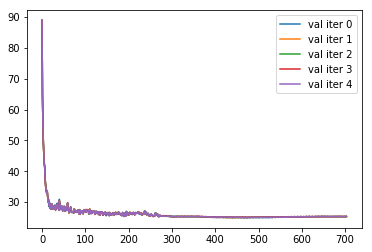

In [19]:
utils.plot_error_on_iterations(history_3, [None, None], [0, 1, 2, 3, 4])

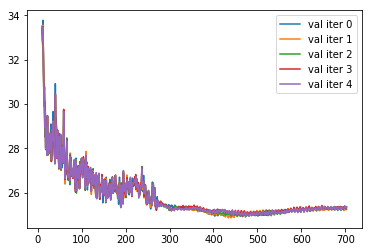

In [20]:
utils.plot_error_on_iterations(history_3, [10, None], [0, 1, 2, 3, 4])

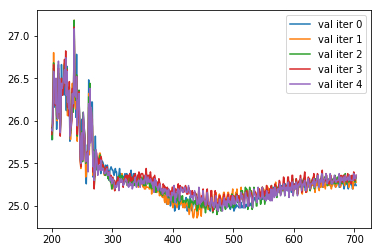

In [21]:
utils.plot_error_on_iterations(history_3, [200, None], [0, 1, 2, 3, 4])

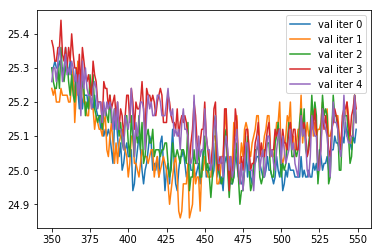

In [22]:
utils.plot_error_on_iterations(history_3, [350, 550], [0, 1, 2, 3, 4])

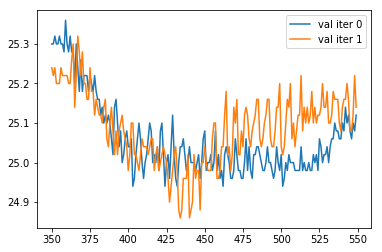

In [23]:
utils.plot_error_on_iterations(history_3, [350, 550], [0, 1])

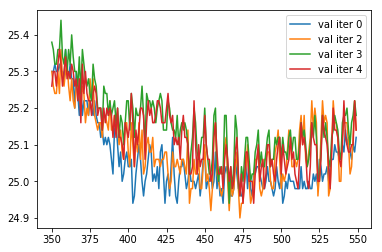

In [24]:
utils.plot_error_on_iterations(history_3, [350, 550], [0, 2, 3, 4])

## Insert three layers (100, 100, 100) for each gate and bias

In [9]:
# took architecture from here: https://github.com/tensorflow/models/blob/f798e4b5504b0b7ed08f7b7a03fc5a79f00b9f21/tutorials/image/cifar10/cifar10.py#L188

def model_step(input_images, prior, batch_size, training, num_labels, use_priors):
    """The Model definition."""
    def get_gates_and_bias(layer_sizes):
        gates = prior
        bias = prior
        for size in layer_sizes[:-1]:
            gates = tf.layers.dense(inputs=gates, units=size, activation=tf.nn.relu)
            bias = tf.layers.dense(inputs=bias, units=size, activation=tf.nn.relu)
        gates = tf.layers.dense(inputs=gates, units=layer_sizes[-1], activation=tf.nn.sigmoid)
        bias = tf.layers.dense(inputs=bias, units=layer_sizes[-1], activation=None)
        return gates, bias
        
    def apply_gating_on_conv(tensor, layer_sizes):
        if not use_priors:
            return tensor
        num_channels = tensor.get_shape()[-1]
        gates, bias = get_gates_and_bias(layer_sizes + (num_channels, ))
        gates = tf.expand_dims(tf.expand_dims(gates, axis=1), axis=1)
        bias = tf.expand_dims(tf.expand_dims(bias, axis=1), axis=1)
        return tf.multiply(tensor, gates) + bias
    
    def apply_gating_on_dense(tensor, layer_sizes):
        if not use_priors:
            return tensor
        num_units = tensor.get_shape()[1]
        gates, bias = get_gates_and_bias(layer_sizes + (num_units, ))
        return tf.multiply(tensor, gates) + bias
    
    LAYERS = (100, 100, 100)
    
    inputs = input_images
    
    conv1 = tf.layers.conv2d(
        inputs=inputs,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2, padding='same')
    
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    norm1 = apply_gating_on_conv(norm1, LAYERS)

    conv2 = tf.layers.conv2d(
        inputs=norm1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    norm2 = apply_gating_on_conv(norm2, LAYERS)
    
    pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2, padding='same')
    
    pool2_shape = pool2.get_shape()
    num_units_after_conv = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]

    pool2_flat = tf.reshape(pool2, [-1, num_units_after_conv])
    pool2_flat = apply_gating_on_dense(pool2_flat, LAYERS)
    
    
    dense1 = tf.layers.dense(inputs=pool2_flat, units=384, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    dense1 = apply_gating_on_dense(dense1, LAYERS)
    
    dense2 = tf.layers.dense(inputs=dense1, units=192, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    dense2 = apply_gating_on_dense(dense2, LAYERS)

    logits = tf.layers.dense(inputs=dense2, units=num_labels)
    logits = apply_gating_on_dense(logits, LAYERS)
    posteriors = tf.nn.softmax(logits)
    
    return logits, posteriors


def apply(input_images, training, train_labels_node, num_labels, use_priors):
    results = []
    loss = 0.0

    batch_size = input_images.get_shape()[0]
    priors = tf.ones((batch_size, num_labels)) / num_labels
    for step in range(NUM_UNROLL_STEPS):
        with tf.variable_scope('one_step', reuse=(step > 0)):
            logits, posteriors = model_step(input_images, priors, batch_size,
                                            training=training, num_labels=num_labels,
                                            use_priors=use_priors)
        priors = posteriors
        results.append((logits, posteriors))
        loss += tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=train_labels_node, logits=logits))
    return tf.stack([logits for (logits, _) in results]), loss

In [10]:
use_priors = True

tf.reset_default_graph()

dataset = utils.get_dataset(DATASET)

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=tf.float32)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    1e-3,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    dataset.train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_config = dict(
    optimizer=optimizer,
    batch_var=batch,
    learning_rate_var=learning_rate,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    eval_frequency=EVAL_FREQUENCY,
)

history_2, stdout_lines = utils.run_train(apply, train_config, dataset,
                                          build_func_kwargs=dict(use_priors=use_priors))

Initialized!
Step 0 (epoch 0.00), 61.3 ms
Minibatch loss: 11.445, learning rate: 0.001000
Minibatch error: [85.9375, 85.9375, 85.9375, 85.9375, 85.9375]
Validation error: [89.62, 89.62, 89.62, 89.62, 89.62]
Step 100 (epoch 0.14), 260.4 ms
Minibatch loss: 9.145, learning rate: 0.001000
Minibatch error: [68.75, 65.625, 65.625, 65.625, 65.625]
Validation error: [62.06, 62.12, 62.14, 62.08, 62.1]
Step 200 (epoch 0.28), 260.9 ms
Minibatch loss: 7.388, learning rate: 0.001000
Minibatch error: [48.4375, 48.4375, 48.4375, 48.4375, 48.4375]
Validation error: [53.84, 54.24, 53.96, 54.06, 54.02]
Step 300 (epoch 0.43), 260.9 ms
Minibatch loss: 6.892, learning rate: 0.001000
Minibatch error: [51.5625, 51.5625, 51.5625, 51.5625, 51.5625]
Validation error: [50.08, 50.0, 49.88, 49.9, 49.88]
Step 400 (epoch 0.57), 260.8 ms
Minibatch loss: 6.760, learning rate: 0.001000
Minibatch error: [53.125, 48.4375, 51.5625, 48.4375, 48.4375]
Validation error: [46.56, 45.64, 46.02, 45.9, 46.04]
Step 500 (epoch 0.71

Step 3700 (epoch 5.26), 260.1 ms
Minibatch loss: 0.280, learning rate: 0.000774
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.939999999999998, 26.620000000000005, 26.659999999999997, 26.700000000000003, 26.72]
Step 3800 (epoch 5.40), 259.9 ms
Minibatch loss: 0.927, learning rate: 0.000774
Minibatch error: [6.25, 4.6875, 4.6875, 4.6875, 4.6875]
Validation error: [27.519999999999996, 27.64, 27.560000000000002, 27.560000000000002, 27.560000000000002]
Step 3900 (epoch 5.55), 260.2 ms
Minibatch loss: 0.471, learning rate: 0.000774
Minibatch error: [3.125, 3.125, 1.5625, 1.5625, 1.5625]
Validation error: [27.739999999999995, 27.5, 27.58, 27.58, 27.64]
Step 4000 (epoch 5.69), 259.6 ms
Minibatch loss: 0.421, learning rate: 0.000774
Minibatch error: [1.5625, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [29.480000000000004, 29.5, 29.58, 29.519999999999996, 29.599999999999994]
Step 4100 (epoch 5.83), 259.0 ms
Minibatch loss: 0.840, learning rate: 0.000774
Minibatch error: 

Step 7400 (epoch 10.52), 260.1 ms
Minibatch loss: 0.035, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.700000000000003, 26.599999999999994, 26.58, 26.58, 26.58]
Step 7500 (epoch 10.67), 260.1 ms
Minibatch loss: 0.023, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.08, 26.760000000000005, 26.760000000000005, 26.760000000000005, 26.760000000000005]
Step 7600 (epoch 10.81), 260.2 ms
Minibatch loss: 0.136, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.980000000000004, 26.879999999999995, 26.879999999999995, 26.900000000000006, 26.86]
Step 7700 (epoch 10.95), 259.2 ms
Minibatch loss: 0.071, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.86, 26.060000000000002, 26.060000000000002, 25.980000000000004, 26.060000000000002]
Step 7800 (epoch 11.09), 260.3 ms
Minibatch loss: 0.051, learning rate: 0.000569
Minibatch error: [0.0, 0.

Step 11100 (epoch 15.79), 260.1 ms
Minibatch loss: 0.020, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.819999999999993, 26.040000000000006, 25.939999999999998, 26.060000000000002, 25.959999999999994]
Step 11200 (epoch 15.93), 259.8 ms
Minibatch loss: 0.018, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.72, 25.739999999999995, 25.900000000000006, 25.86, 25.879999999999995]
Step 11300 (epoch 16.07), 260.2 ms
Minibatch loss: 0.020, learning rate: 0.000440
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.5, 26.519999999999996, 26.620000000000005, 26.560000000000002, 26.64]
Step 11400 (epoch 16.21), 260.1 ms
Minibatch loss: 0.016, learning rate: 0.000440
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.260000000000005, 26.480000000000004, 26.459999999999994, 26.480000000000004, 26.439999999999998]
Step 11500 (epoch 16.36), 261.0 ms
Minibatch loss: 0.055, learning rate: 0.00

Step 14800 (epoch 21.05), 260.1 ms
Minibatch loss: 0.017, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.040000000000006, 25.040000000000006, 25.08, 25.0, 25.08]
Step 14900 (epoch 21.19), 260.7 ms
Minibatch loss: 0.008, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.060000000000002, 25.040000000000006, 25.019999999999996, 25.060000000000002, 25.019999999999996]
Step 15000 (epoch 21.33), 261.0 ms
Minibatch loss: 0.010, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.28, 25.28, 25.200000000000003, 25.260000000000005, 25.22]
Step 15100 (epoch 21.48), 259.9 ms
Minibatch loss: 0.003, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.299999999999997, 25.36, 25.340000000000003, 25.340000000000003, 25.36]
Step 15200 (epoch 21.62), 260.4 ms
Minibatch loss: 0.014, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Vali

Step 18500 (epoch 26.31), 260.6 ms
Minibatch loss: 0.001, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.959999999999994, 25.159999999999997, 25.180000000000007, 25.239999999999995, 25.180000000000007]
Step 18600 (epoch 26.45), 259.9 ms
Minibatch loss: 0.005, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.120000000000005, 25.060000000000002, 25.019999999999996, 25.0, 25.019999999999996]
Step 18700 (epoch 26.60), 260.2 ms
Minibatch loss: 0.007, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.08, 25.099999999999994, 25.060000000000002, 25.099999999999994, 25.099999999999994]
Step 18800 (epoch 26.74), 260.0 ms
Minibatch loss: 0.002, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.36, 25.400000000000006, 25.379999999999995, 25.379999999999995, 25.379999999999995]
Step 18900 (epoch 26.88), 260.3 ms
Minibatch loss: 0.001, learni

Step 22200 (epoch 31.57), 258.4 ms
Minibatch loss: 0.000, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.840000000000003, 24.900000000000006, 24.900000000000006, 24.879999999999995, 24.92]
Step 22300 (epoch 31.72), 258.5 ms
Minibatch loss: 0.001, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.42, 24.480000000000004, 24.480000000000004, 24.42, 24.42]
Step 22400 (epoch 31.86), 258.6 ms
Minibatch loss: 0.006, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.72, 24.760000000000005, 24.78, 24.819999999999993, 24.819999999999993]
Step 22500 (epoch 32.00), 258.3 ms
Minibatch loss: 0.002, learning rate: 0.000194
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.680000000000007, 24.900000000000006, 24.879999999999995, 24.900000000000006, 24.900000000000006]
Step 22600 (epoch 32.14), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000194
Minibatch error: [0.

Step 25900 (epoch 36.84), 258.8 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 24.379999999999995, 24.319999999999993, 24.299999999999997, 24.299999999999997]
Step 26000 (epoch 36.98), 258.6 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.239999999999995, 24.379999999999995, 24.340000000000003, 24.319999999999993, 24.319999999999993]
Step 26100 (epoch 37.12), 258.4 ms
Minibatch loss: 0.000, learning rate: 0.000150
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.299999999999997, 24.400000000000006, 24.379999999999995, 24.340000000000003, 24.36]
Step 26200 (epoch 37.26), 258.5 ms
Minibatch loss: 0.000, learning rate: 0.000150
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.379999999999995, 24.379999999999995, 24.319999999999993, 24.36]
Step 26300 (epoch 37.40), 258.6 ms
Minibatch loss: 0.000, learn

Step 29600 (epoch 42.10), 258.8 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.019999999999996, 24.08, 24.060000000000002, 24.099999999999994, 24.08]
Step 29700 (epoch 42.24), 258.4 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.0, 24.08, 24.14, 24.159999999999997, 24.14]
Step 29800 (epoch 42.38), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.980000000000004, 23.980000000000004, 24.060000000000002, 24.099999999999994, 24.099999999999994]
Step 29900 (epoch 42.52), 258.4 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.939999999999998, 23.980000000000004, 23.980000000000004, 24.060000000000002, 24.040000000000006]
Step 30000 (epoch 42.67), 258.4 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0

Step 33300 (epoch 47.36), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.739999999999995, 23.840000000000003, 23.900000000000006, 23.92, 23.900000000000006]
Step 33400 (epoch 47.50), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.760000000000005, 23.86, 23.819999999999993, 23.86, 23.86]
Step 33500 (epoch 47.64), 258.4 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.72, 23.86, 23.840000000000003, 23.879999999999995, 23.879999999999995]
Step 33600 (epoch 47.79), 258.6 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.739999999999995, 23.879999999999995, 23.900000000000006, 23.959999999999994, 23.92]
Step 33700 (epoch 47.93), 258.8 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 

Step 37000 (epoch 52.62), 259.3 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.739999999999995, 23.739999999999995, 23.760000000000005, 23.739999999999995, 23.78]
Step 37100 (epoch 52.76), 259.2 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.739999999999995, 23.78, 23.78, 23.799999999999997, 23.86]
Step 37200 (epoch 52.91), 259.5 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.700000000000003, 23.78, 23.840000000000003, 23.879999999999995, 23.879999999999995]
Step 37300 (epoch 53.05), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000066
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.760000000000005, 23.739999999999995, 23.819999999999993, 23.840000000000003, 23.86]
Step 37400 (epoch 53.19), 259.1 ms
Minibatch loss: 0.000, learning rate: 0.000066
Minibatch error: [0.

Step 40700 (epoch 57.88), 259.1 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.680000000000007, 23.700000000000003, 23.739999999999995, 23.760000000000005, 23.739999999999995]
Step 40800 (epoch 58.03), 259.1 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.680000000000007, 23.659999999999997, 23.680000000000007, 23.700000000000003, 23.680000000000007]
Step 40900 (epoch 58.17), 259.2 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.64, 23.72, 23.64, 23.659999999999997, 23.620000000000005]
Step 41000 (epoch 58.31), 259.2 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.659999999999997, 23.72, 23.659999999999997, 23.700000000000003, 23.700000000000003]
Step 41100 (epoch 58.45), 259.0 ms
Minibatch loss: 0.000, learning rate: 0.0

Step 44400 (epoch 63.15), 259.3 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.620000000000005, 23.620000000000005, 23.599999999999994, 23.659999999999997, 23.64]
Step 44500 (epoch 63.29), 259.0 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.620000000000005, 23.58, 23.620000000000005, 23.680000000000007, 23.659999999999997]
Step 44600 (epoch 63.43), 259.3 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.64, 23.560000000000002, 23.519999999999996, 23.620000000000005, 23.620000000000005]
Step 44700 (epoch 63.57), 259.0 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.680000000000007, 23.659999999999997, 23.64, 23.72, 23.700000000000003]
Step 44800 (epoch 63.72), 258.9 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibat

Step 48100 (epoch 68.41), 258.6 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.680000000000007, 23.78, 23.819999999999993, 23.879999999999995, 23.86]
Step 48200 (epoch 68.55), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.799999999999997, 23.819999999999993, 23.819999999999993, 23.840000000000003, 23.840000000000003]
Step 48300 (epoch 68.69), 258.8 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.760000000000005, 23.799999999999997, 23.799999999999997, 23.86, 23.819999999999993]
Step 48400 (epoch 68.84), 259.0 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.78, 23.760000000000005, 23.760000000000005, 23.78, 23.78]
Step 48500 (epoch 68.98), 258.6 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.

Step 51800 (epoch 73.67), 258.9 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.879999999999995, 23.840000000000003, 23.799999999999997, 23.86, 23.840000000000003]
Step 51900 (epoch 73.81), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.799999999999997, 23.86, 23.86, 23.879999999999995, 23.86]
Step 52000 (epoch 73.96), 258.9 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.86, 23.879999999999995, 23.819999999999993, 23.840000000000003, 23.840000000000003]
Step 52100 (epoch 74.10), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000022
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.739999999999995, 23.879999999999995, 23.799999999999997, 23.819999999999993, 23.799999999999997]
Step 52200 (epoch 74.24), 259.0 ms
Minibatch loss: 0.000, learning rate: 0.000022
Minibat

Step 55500 (epoch 78.93), 258.8 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.840000000000003, 23.879999999999995, 23.900000000000006, 23.92, 23.92]
Step 55600 (epoch 79.08), 258.9 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.78, 23.879999999999995, 23.879999999999995, 23.939999999999998, 23.92]
Step 55700 (epoch 79.22), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.840000000000003, 23.92, 23.879999999999995, 23.92, 23.92]
Step 55800 (epoch 79.36), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.819999999999993, 23.980000000000004, 23.959999999999994, 23.980000000000004, 23.959999999999994]
Step 55900 (epoch 79.50), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 

Step 59100 (epoch 84.05), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.819999999999993, 23.92, 23.879999999999995, 23.879999999999995, 23.879999999999995]
Step 59200 (epoch 84.20), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.819999999999993, 23.939999999999998, 23.879999999999995, 23.939999999999998, 23.980000000000004]
Step 59300 (epoch 84.34), 258.8 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.840000000000003, 23.959999999999994, 23.900000000000006, 23.939999999999998, 23.939999999999998]
Step 59400 (epoch 84.48), 258.9 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.840000000000003, 23.900000000000006, 23.980000000000004, 23.980000000000004, 23.939999999999998]
Step 59500 (epoch 84.62), 258.8 ms
Mi

Step 62700 (epoch 89.17), 259.0 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.900000000000006, 23.900000000000006, 23.86, 23.900000000000006, 23.879999999999995]
Step 62800 (epoch 89.32), 258.8 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.92, 23.959999999999994, 23.900000000000006, 23.92, 23.939999999999998]
Step 62900 (epoch 89.46), 258.8 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.840000000000003, 23.959999999999994, 23.939999999999998, 23.939999999999998, 23.92]
Step 63000 (epoch 89.60), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.900000000000006, 24.060000000000002, 24.019999999999996, 24.019999999999996, 24.0]
Step 63100 (epoch 89.74), 258.9 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatc

Step 66400 (epoch 94.44), 258.6 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.86, 24.040000000000006, 23.959999999999994, 23.959999999999994, 23.959999999999994]
Step 66500 (epoch 94.58), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.900000000000006, 24.019999999999996, 24.0, 24.040000000000006, 24.019999999999996]
Step 66600 (epoch 94.72), 258.8 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.939999999999998, 24.099999999999994, 24.019999999999996, 24.0, 23.959999999999994]
Step 66700 (epoch 94.86), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.980000000000004, 24.14, 24.08, 24.08, 24.08]
Step 66800 (epoch 95.00), 258.7 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.

Step 70000 (epoch 99.56), 258.5 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.92, 24.040000000000006, 24.019999999999996, 24.040000000000006, 24.019999999999996]
Step 70100 (epoch 99.70), 258.5 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.92, 24.08, 24.0, 24.0, 24.0]
Step 70200 (epoch 99.84), 258.4 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.959999999999994, 24.08, 24.040000000000006, 24.019999999999996, 24.040000000000006]
Step 70300 (epoch 99.98), 258.2 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.939999999999998, 24.0, 23.959999999999994, 24.0, 23.980000000000004]
Test error: [25.189999999999998, 25.230000000000004, 25.209999999999994, 25.230000000000004, 25.22]


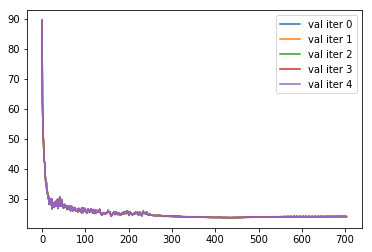

In [25]:
utils.plot_error_on_iterations(history_2, [None, None], [0, 1, 2, 3, 4])

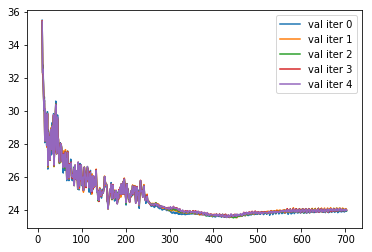

In [26]:
utils.plot_error_on_iterations(history_2, [10, None], [0, 1, 2, 3, 4])

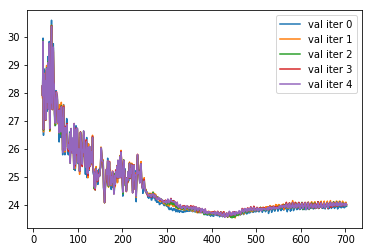

In [27]:
utils.plot_error_on_iterations(history_2, [20, None], [0, 1, 2, 3, 4])

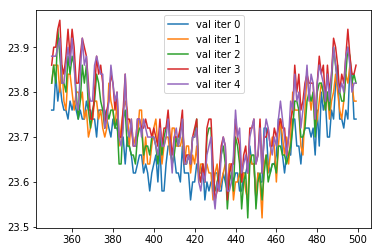

In [28]:
utils.plot_error_on_iterations(history_2, [350, 500], [0, 1, 2, 3, 4])